### First import

The most important libraries are the ones described below:
`itertools`, wich implements a number of iterator building blocks inspired by constructs from APL, Haskell, and SML
`rasterio` that reads and writes gridded raster datasets and provides a Python API based on Numpy N-dimensional arrays and GeoJSON)
`keras`, which solves machine learning problems, with a focus on modern deep learning, based on Tensorflow.

In [ ]:
import os
import math
import numpy as np
import rasterio
import cv2
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from numpy import argmax

For the processing the functions that will read and plot each of the bands form the images `loadimg()` and read the tiles size for each image `tile()` are needed to be defined. 

In [3]:
def loadimg(filename):
    # Open a single band and plot
    with rasterio.open(filename) as src:
        a = src.read()
        nbands = src.count
        nrows = src.height
        ncolumns = src.width
    image = np.empty([nrows, ncolumns, nbands])
    for i in range(nbands):
        image[:, :, i] = a[i, :, :]
    return image

def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
        img.crop(box).save(out)

Once, the data import can be started.
The path for importing the raw images needs to be set. In the 'Visualize the first image' section, the image to be processed can be chosen.

['/Users/mac/Library/CloudStorage/OneDrive-TUM/masters/1 sem/Selected topics/BBKI_drone_debris_detection/attempt 6/Ecstall_drone_data/DJI_0708.JPG', '/Users/mac/Library/CloudStorage/OneDrive-TUM/masters/1 sem/Selected topics/BBKI_drone_debris_detection/attempt 6/Ecstall_drone_data/DJI_0682.JPG', '/Users/mac/Library/CloudStorage/OneDrive-TUM/masters/1 sem/Selected topics/BBKI_drone_debris_detection/attempt 6/Ecstall_drone_data/DJI_0684.JPG', '/Users/mac/Library/CloudStorage/OneDrive-TUM/masters/1 sem/Selected topics/BBKI_drone_debris_detection/attempt 6/Ecstall_drone_data/DJI_0686.JPG', '/Users/mac/Library/CloudStorage/OneDrive-TUM/masters/1 sem/Selected topics/BBKI_drone_debris_detection/attempt 6/Ecstall_drone_data/DJI_0700.JPG', '/Users/mac/Library/CloudStorage/OneDrive-TUM/masters/1 sem/Selected topics/BBKI_drone_debris_detection/attempt 6/Ecstall_drone_data/DJI_0702.JPG', '/Users/mac/Library/CloudStorage/OneDrive-TUM/masters/1 sem/Selected topics/BBKI_drone_debris_detection/attempt

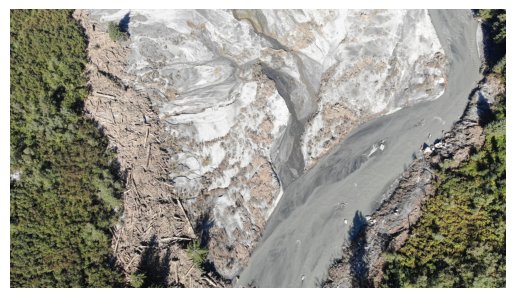

In [4]:
###########  Data Import #############



##You can also define your own path/name here
dir_image = r"/Users/Hydra/Documents/CATOGRAPHY M.Sc/TUM/SELTOP/BBKI_drone_debris_detection/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data"
dir_tile = r"Users/Hydra/Documents/CATOGRAPHY M.Sc/TUM/SELTOP/BBKI_drone_debris_detection/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/tiles"


dir_image_JPG = dir_image + "/*.JPG"
raw_images = glob.glob(dir_image_JPG)
print(raw_images)

filenames = [os.path.basename(x) for x in glob.glob(dir_image_JPG)]

print(filenames)


###########  Visualize the first image #############
## Here you can show the image you are processing by changing the numbers 0,1,2,3 etc.
img = mpimg.imread(raw_images[0])
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

As the image is considered to be to bright and some spots can be mistaken as a different group to be recognized, the contrast and the brightness of the image is to be changed. The contrast and brightness for each image was redeuced on a 66% and 50% respectively. The comparison is shown below.

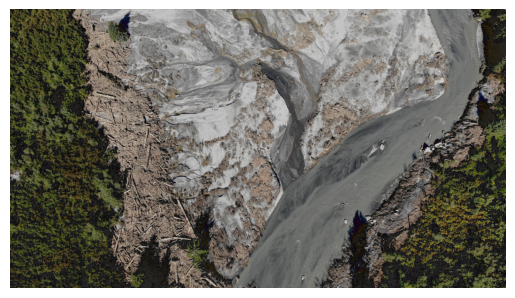

In [5]:
alpha = 1 # Contrast control (1.0-3.0)
beta = -50 # Brightness control (0-100)

adjusted = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

imgplot = plt.imshow(adjusted)
plt.axis('off')
plt.show()

Now, for a nice comparison, the input image needs to be tiled as the training set size for a correct recognition (64x64 pixels). From `filenames` variable, the chosen image needs to be defined. 

In [6]:
patch_size = 64

image = loadimg("/Users/Hydra/Documents/CATOGRAPHY M.Sc/TUM/SELTOP/BBKI_drone_debris_detection/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/DJI_0686.JPG")
pixel_x, pixel_y, bands= image.shape
print("Raw Images are of: " + str(pixel_x) + " x " + str(pixel_y) +" pixels")

#tile(filenames[3], dir_image, dir_tile, patch_size)
#print("Image tiling is now successful!")

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Raw Images are of: 2280 x 4056 pixels


As for the model application, the Deep Neural Network priorly trained is imported.

In [7]:
from tensorflow import keras
model = keras.models.load_model('/Users/Hydra/Documents/CATOGRAPHY M.Sc/TUM/SELTOP/BBKI_drone_debris_detection/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/attempt 6')

2023-02-06 23:28:38.936564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The model down described takes each of the tiles for the chosen image from `adjusted`.
It compares the information contained by tile and predicts weather it is debris, forest or water. It also displays the time it takes for each of the tiles to be processed.

In [8]:
x = 0
y = 0
categories = ['debris', 'forest', 'water']
img = np.array(adjusted)

for i in range (0,pixel_x//64+1):
    y = 0
    for k in range (0, pixel_y//64+1):
        test_data=[]
        test_data = img[x:x+64,y:y+64]/255.0
        try:
            test_data=test_data.reshape([-1,64, 64, 3])
            pred = model.predict(test_data)
            predictions = argmax(pred, axis=1)
            if categories[predictions[0]] == "debris":
                for j in img[x:x+64,y:y+64]:
                    for l in range(0,64):
                        j[l] = 255, 255, 0
            elif categories[predictions[0]] == "forest":
                for j in img[x:x+64,y:y+64]:
                    for l in range(0,64):
                        j[l] = 0, 153, 0
            elif categories[predictions[0]] == "water":
                for j in img[x:x+64,y:y+64]:
                    for l in range(0,64):
                        j[l] = 0, 0, 255
        except ValueError:
            pass
        y += 64
    x += 64 

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 137ms/step


Finally, the predicted tiles are displayed over the chosen image, so the accuracy of the model can be visualy judged.
Debris is selected as yellow, water as blue and forest as green.

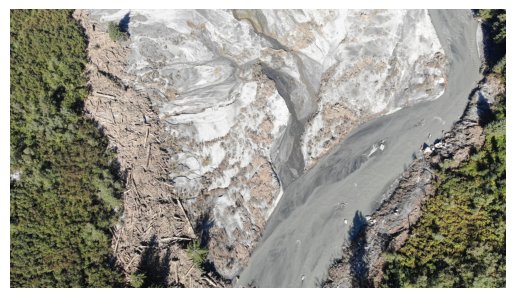

In [10]:
img1 = mpimg.imread(raw_images[0])
imgplot = plt.imshow(img1)
plt.axis('off')
plt.show()

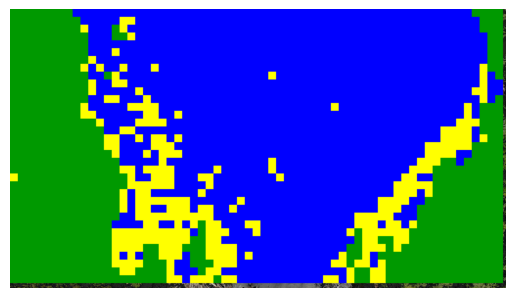

In [11]:
imgplot = plt.imshow(img)
plt.axis('off')
plt.show() 

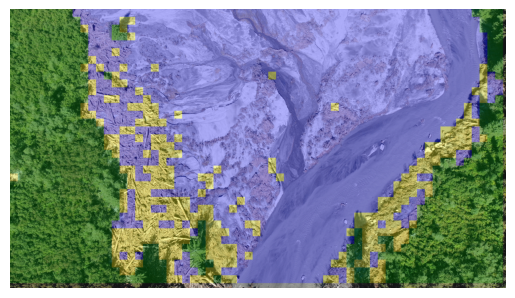

In [12]:
img1 = mpimg.imread(raw_images[0])
plt.imshow(img1)
plt.imshow(img, alpha = 0.3)
plt.axis('off')
plt.show()

The elaborated code was able to accurately predict deadwood regions in the aerial imagery with the help of a CNN, with a high degree of correspondence between the actual and predicted regions.